In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from PIL import Image
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
torch.manual_seed(1)

In [4]:
def load_mnist_data(train_batch_size, test_batch_size):
    train_data = datasets.MNIST('data', train=True, download=True,
                transform=transforms.Compose([
                transforms.Resize((32,32)),
                transforms.ToTensor(),
                transforms.Normalize((0.1180,), (0.2987,))
                ]))
    temp_targets = torch.tensor(np.random.randint(0, 10, (len(train_data)),))
    train_data.targets = temp_targets
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=train_batch_size, shuffle=True)

    test_data = datasets.MNIST('data', train=False,
                transform=transforms.Compose([
                transforms.Resize((32, 32)),
                transforms.ToTensor(),
                transforms.Normalize((0.1180,), (0.2987,))
                ]))
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=test_batch_size, shuffle=True)

    return (train_loader, test_loader)

In [5]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.layer1 = nn.Conv2d(1, 6, 5)
        self.layer2 = nn.Conv2d(6, 16, 5)
        self.fc_layer1 = nn.Linear(16 * 5 * 5, 120)
        self.fc_layer2 = nn.Linear(120, 84)
        self.fc_layer3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.layer1(x)), 2)
        x = F.max_pool2d(F.relu(self.layer2(x)), 2)
        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc_layer1(x))
        x = F.relu(self.fc_layer2(x))
        x = self.fc_layer3(x)
        return x

In [6]:
train_batch_size = 100
test_batch_size = 100
train_loader, test_loader = load_mnist_data(train_batch_size, test_batch_size)

In [7]:
def train_model(cnn_model, optimizer_fn, data_loader):
    cnn_model.train()
    correct_preds = 0
    total_train_loss = 0

    for batch_idx, (data_batch, target_batch) in enumerate(data_loader):
        data_batch, target_batch = Variable(data_batch), Variable(target_batch)
        optimizer_fn.zero_grad()
        output_batch = cnn_model(data_batch)
        loss_value = loss_function(output_batch, target_batch)
        loss_value.backward()
        optimizer_fn.step()

        total_train_loss += loss_value.data

        predicted = np.argmax(output_batch.data, axis=1)
        correct_preds += np.equal(predicted, target_batch.data).sum()
    
    avg_train_loss = (total_train_loss * 100) / len(data_loader.dataset)
    train_accuracy = 100.0 * correct_preds / len(data_loader.dataset)
    return avg_train_loss, train_accuracy

In [8]:
def evaluate_model(cnn_model, epoch_idx, data_loader):
    cnn_model.eval()
    total_test_loss = 0
    correct_preds = 0

    for data_batch, target_batch in data_loader:
        data_batch, target_batch = Variable(data_batch), Variable(target_batch)
        output_batch = cnn_model(data_batch)
        loss_value = loss_function(output_batch, target_batch)
        total_test_loss += loss_value.data

        predicted = np.argmax(output_batch.data, axis=1)
        correct_preds += np.equal(predicted, target_batch.data).sum()

    avg_test_loss = (total_test_loss * 100) / len(data_loader.dataset)
    print('\nTest set, Epoch {} , Avg loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        epoch_idx, avg_test_loss, correct_preds, len(data_loader.dataset),
        100. * correct_preds / len(data_loader.dataset)))
    return avg_test_loss

In [9]:
cnn_model = SimpleCNN()

optimizer_fn = optim.Adam(cnn_model.parameters(), lr=0.0001)
train_loss_history = []
test_loss_history = []

epochs = 75
loss_function = torch.nn.CrossEntropyLoss()
for epoch_idx in range(1, epochs + 1):
    avg_train_loss, train_accuracy = train_model(cnn_model, optimizer_fn, train_loader)
    train_loss_history.append(avg_train_loss)
    avg_test_loss = evaluate_model(cnn_model, epoch_idx, test_loader)
    test_loss_history.append(avg_test_loss)
    print('Epoch: ', epoch_idx)
    print('Training Loss: ', avg_train_loss)


Test set, Epoch 1 , Avg loss: 2.3016, Accuracy: 529/10000 (5%)

Epoch:  1
Training Loss:  tensor(2.3033)

Test set, Epoch 2 , Avg loss: 2.3019, Accuracy: 729/10000 (7%)

Epoch:  2
Training Loss:  tensor(2.3025)

Test set, Epoch 3 , Avg loss: 2.3039, Accuracy: 626/10000 (6%)

Epoch:  3
Training Loss:  tensor(2.3020)

Test set, Epoch 4 , Avg loss: 2.3071, Accuracy: 670/10000 (7%)

Epoch:  4
Training Loss:  tensor(2.3016)

Test set, Epoch 5 , Avg loss: 2.3073, Accuracy: 766/10000 (8%)

Epoch:  5
Training Loss:  tensor(2.3011)

Test set, Epoch 6 , Avg loss: 2.3076, Accuracy: 458/10000 (5%)

Epoch:  6
Training Loss:  tensor(2.3003)

Test set, Epoch 7 , Avg loss: 2.3078, Accuracy: 406/10000 (4%)

Epoch:  7
Training Loss:  tensor(2.2995)

Test set, Epoch 8 , Avg loss: 2.3077, Accuracy: 689/10000 (7%)

Epoch:  8
Training Loss:  tensor(2.2984)

Test set, Epoch 9 , Avg loss: 2.2987, Accuracy: 1159/10000 (12%)

Epoch:  9
Training Loss:  tensor(2.2972)

Test set, Epoch 10 , Avg loss: 2.3106, Accu

In [10]:
train_loss_list = [loss.data.numpy().tolist() for loss in train_loss_history]
test_loss_list = [loss.data.numpy().tolist() for loss in test_loss_history]

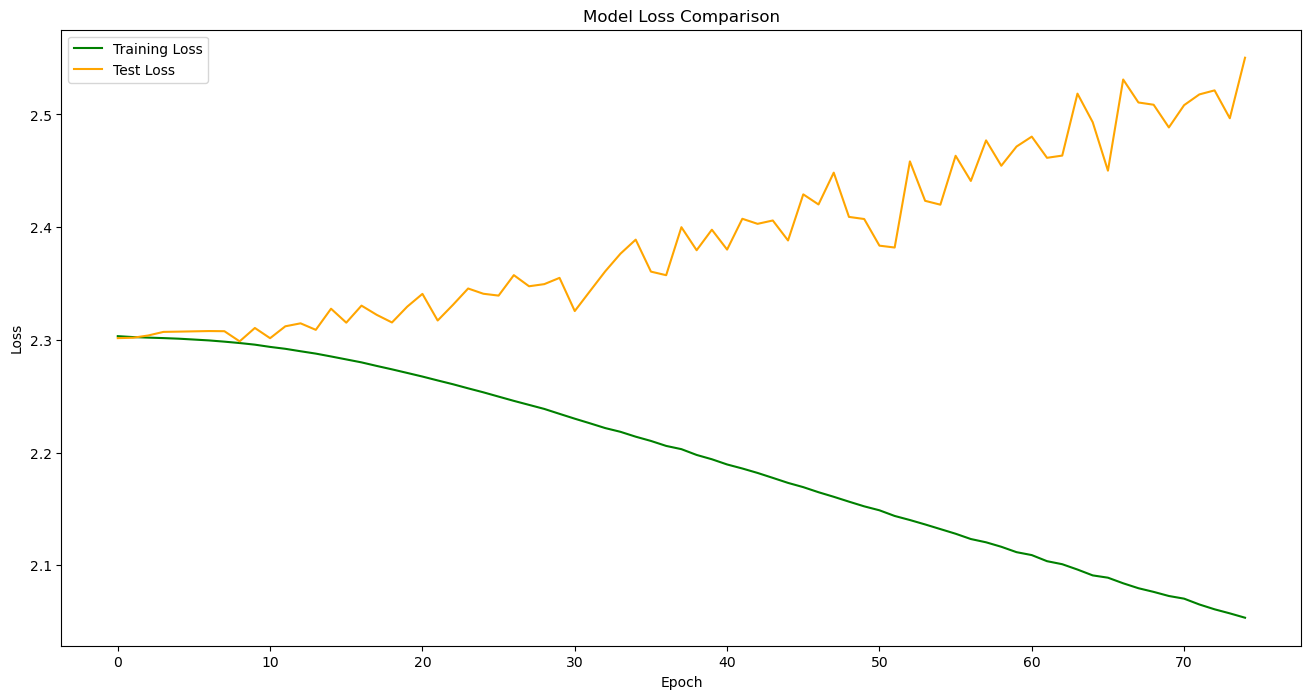

In [11]:
plt.figure(figsize=(16,8))
plt.plot(np.arange(0, 75, 1), train_loss_list, color="green")
plt.plot(np.arange(0, 75, 1), test_loss_list, color="orange")
plt.title('Model Loss Comparison')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()